# Credit Card Fraud 
### (dataset from kaggle.com)

#### Data on credit card transactions has been collected and classified as fraudulent or non-fraudulent (i.e. class = 1 or 0). Datasets on fraud tends to be highly imbalanced, and that is the case for this dataset. In order to adhere to privacy concerns the all features of the dataset have been transformed using Principal Components Analysis (PCA), except for the amount of the transaction and the time between transactions.

#### Consequently, this is a very clean dataset, but it is also of moderate size (i.e 284,807 observations in a csv file of around 150 MB). As a result there will be some memory issues when conducting certain schemes on this standard consumer laptop.

#### We begin by reading in the csv file into a Pandas dataframe.

In [34]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

data=pd.read_csv('creditcard.csv',header=0)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
fraud=data['Class'].sum()
print('Number of fraudulent transactions: '+ str(fraud))
print('---------------------------------------------------------------')
print('Percentage of transactions that are fraudulent: '+str(100*fraud/len(data.index)))
print('---------------------------------------------------------------')
print(data.info())

Number of fraudulent transactions: 492
---------------------------------------------------------------
Percentage of transactions that are fraudulent: 0.00172748563062
---------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       2

#### The above shows us that out of 284,807 transactions only 492 were fraudulent, so there is considerable class imbalance.

#### As noted above this is a very clean dataset, so there is no need for tidying things up. Let's look at some histogram plots and a boxplot or two.

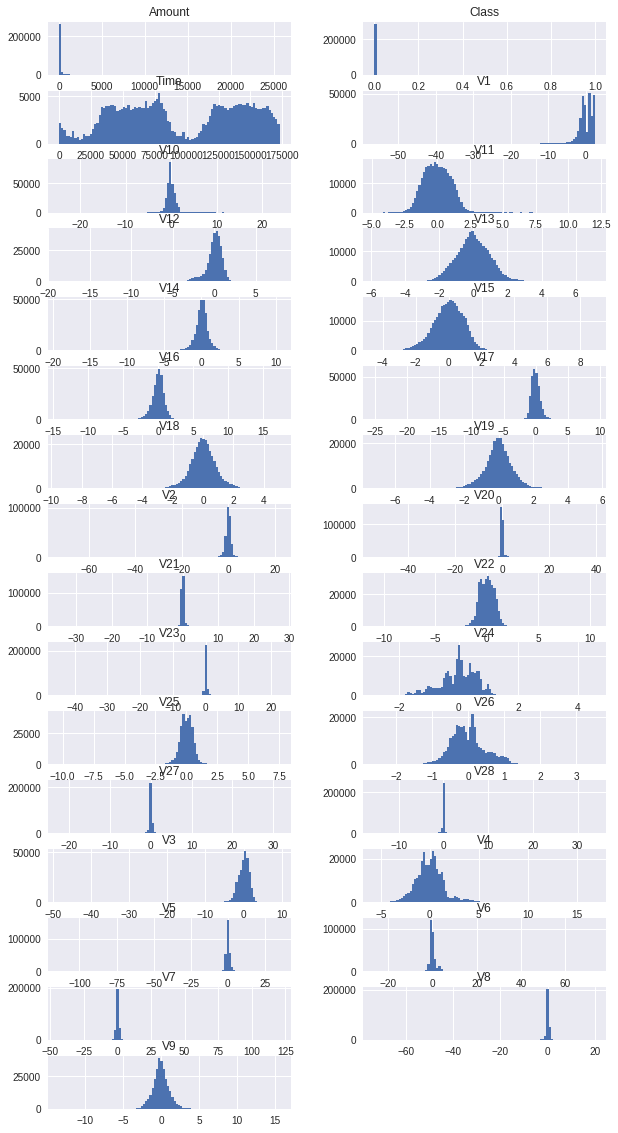

In [4]:
sns.set()
data.hist(bins=100,layout=(16,2),figsize=(10,20))
plt.show()

#### Note that feature names starting with a 'V' are the transformed features resulting from PCA, and as a result they all have a mean of zero. Also many of the transformed features seem to correspond to a centered distribution, but some of them show quite a bit of skew.

#### The histogram plot corresponding to the time between transactions looks to be bimodal. Let's examine a boxplot of time by class to see if anything interesting is going on.

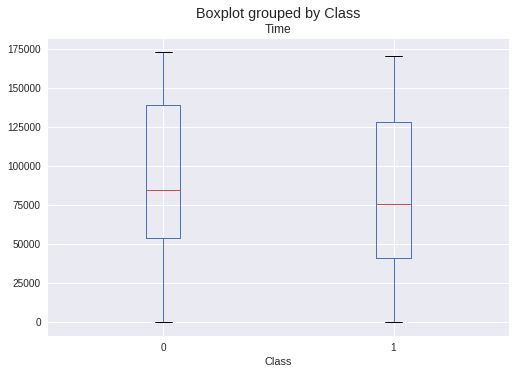

In [5]:
data.boxplot(column='Time',by='Class')
plt.show()

#### The boxplot above seems to indicate that the time between transactions is slightly lower for fraudulent transactions, but there may not be much predictive power. Let's see how a boxplot of purchase amount by class looks.

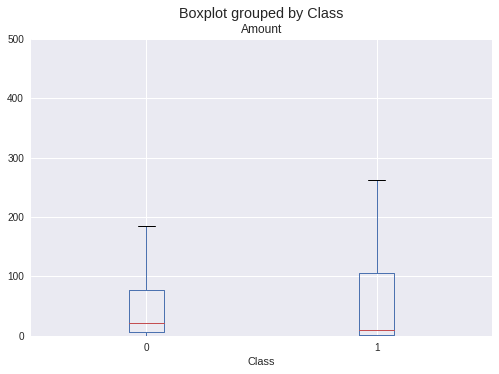

In [6]:
ax=data.boxplot(column='Amount',by='Class')
ax.set_ylim(0,500)
plt.show()

#### The purchase amount of fraudulent transactions has a much greater variance than for non-fraudulent transactions, but the mean is actually lower for fraudulent transactions.

#### Let's look at the correlations among the features and class labels. Note that the features resulting from PCA should be uncorrelated with each other.

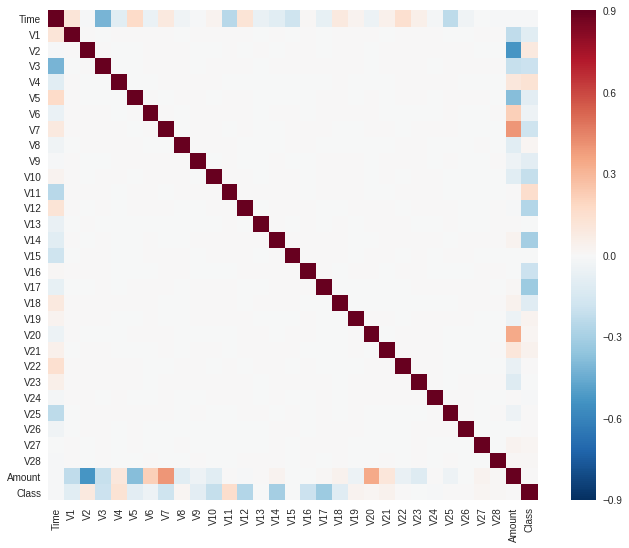

In [7]:
ro=data.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(ro, vmax=0.9, square=True)
plt.show()

#### Note that Time and Amount are individually almost completely uncorrelated with Class.

#### Let's apply PCA to the entire set of features (including Time and Amount), then we can examine if any of these transformed features are significantly responsible for the variation in the Class.

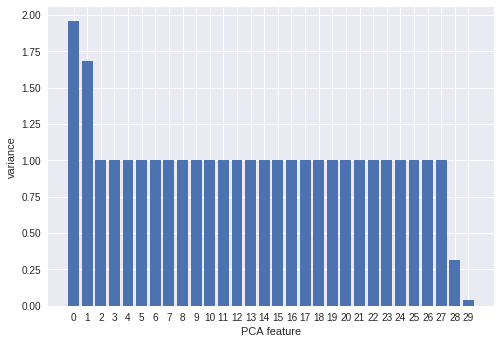

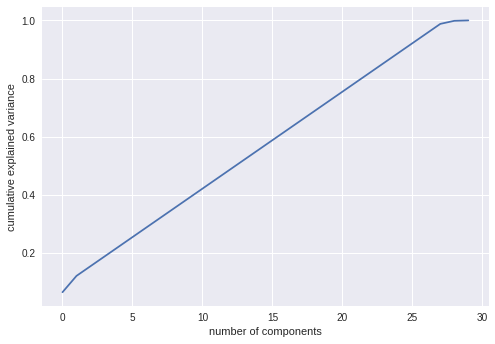

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler=StandardScaler()
pca=PCA()

pipeline = make_pipeline(scaler,pca)

pipeline.fit(data.iloc[:,:-1].values)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

#### The plots above indicate that we could drop at most two of the features, and still capture most of the variance. However, this will not be much of a dimensionality reduction and there don't appear to be dependency issues, so for the moment we proceed with all of the features.

#### Let's start to some predictive models. We begin by applying a test/train split, which we will stratify to insure each set has a similar proportion of fradulent transactions. We also need to decide upon some metrics to measure the performance of the models. Given the high class imbalance accuracy will not be a good metric of performance.

#### Assuming the credit card company's primary goal is to stop fraud we would like our model to correctly identify as many of the fraudulent transactions as possible. This implies that we would like the ratio of correctly identified fraudulent cases over the total number of fraudulent casesto be as high as possible. In statistics this ratio is called 'Recall' (it is also called 'Sensitivity').

#### The recall score will be a big priority for our model, but as a secondary consideration we don't want to annoy customers by consistently marking their transactions as fraudulent when they are actually non-fraudulent. Therefore we will also keep an eye on how many non-fraudulent transactions are incorrectly classified as fraudulent. This information can be found in the 'confusion matrix', and it is also captured in the ratio of correctly classified fraudulent transactions over all transactions classified as fraudulent. This ratio is known as 'Precision', and we will examine a plot of recall versus precision, as well as the area under the curve resulting from plotting recall versus specificity (the latter as we will see it not so useful for an imbalanced class).

#### If we let $Y$ denote the true class and $\hat{Y}$ denote the predicted class, then an equivalent notion of Precision and Recall is given by:

#### $\text{Precision} = P(Y = 1 | \hat{Y} = 1)$
$\text{Recall (Sensitivity)} = P(\hat{Y} = 1 | Y = 1)$

$\text{Specificity} = P(\hat{Y} = 0 | Y = 0)$

#### A final consideration is to not only consider the model's output as 0 or 1, but rather to look at the probability that the transaction is fraudulent. Traditionally, if the probability that the transaction is fraudulent is over 50%, then it will be marked as fraudulent. Later on we may want to lower or raise this threshold. 

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn import metrics

X=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=21,stratify=y)


#### Here'a little code I like to nicely display the confusion matrix.

In [29]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

#### The first model to be fitted is the Naive Bayes classifier. As the name might suggest this is a very simple/naive model, but when it works it is quite efficient.

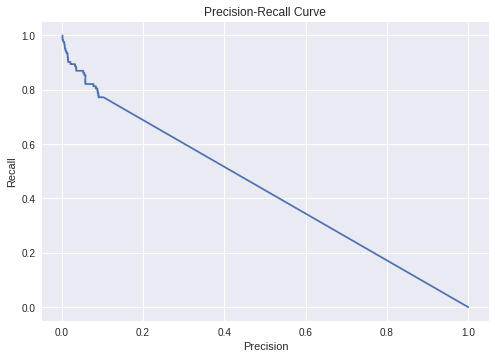

Accuracy: 0.9777253447936856
Recall: 0.8211382113821138
Precision: 0.06066066066066066
AUC: 0.9660934924463414


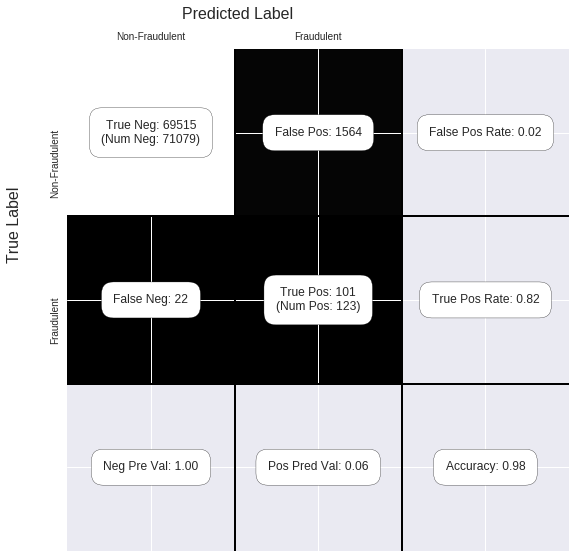

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()),
         ('GNB', GaussianNB())]

pipeline = Pipeline(steps)

pipeline.fit(X_train,y_train)

y_predic = pipeline.predict(X_test)
y_pred = pipeline.predict_proba(X_test)

prec, rec, thresholds = precision_recall_curve(y_test, y_pred[:,1])
plt.plot(prec, rec)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
print("Recall: {}".format(recall_score(y_test, y_predic)))
print("Precision: {}".format(precision_score(y_test, y_predic)))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))
C=confusion_matrix(y_test, y_predic)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### At first glance the performance of this model might seem to be pretty good, since the accuracy is over 97%, and the AUC-ROC score is over 0.96, but around 20% of the fraudulent transactions were misclassified. Accuracy is meaningless in this scenario, since we could simply declare all transactions as fraudulent and the resulting accuracy would be over 99.8%! Likewise the AUC-ROC score seems impressive, but the precision-recall curve is rather disappointing. Going forward we'll rely on the AUC for the precision-recall curve.

#### This model did not take into account the class imbalance (i.e. the scarcity of fraudulent transactions in the dataset), so the non-fraudulent transactions were very influential. One way we can balance out the influence is to randomly subsample from the non-fraudulent transactions, so that the resulting set will have equal representation of fraudulent and non-fraudulent transactions.

In [31]:
import random

non_fraud_index=data.loc[data.Class==0].index
fraud_index=data.loc[data.Class==1].index
sub_sample_index=non_fraud_index[random.sample(range(0,len(non_fraud_index)),492)]
sub_sample_index=sub_sample_index.append(fraud_index)
data_subset=data.loc[sub_sample_index,:]

X_subset=data_subset.iloc[:,:-1].values
y_subset=data_subset.iloc[:,-1].values

X_train_subset,X_test_subset,y_train_subset,y_test_subset=train_test_split(X_subset,y_subset,test_size=0.25,random_state=21,stratify=y_subset)


In [47]:
remaining_index=list(set(data.index)-set(sub_sample_index))
data_remaining=data.loc[remaining_index,:]
X_remaining=data_remaining.iloc[:,:-1].values
y_remaining=data_remaining.iloc[:,-1].values

#### Now we will run the Naive Bayes classifier again, but this time using the balanced subsample.

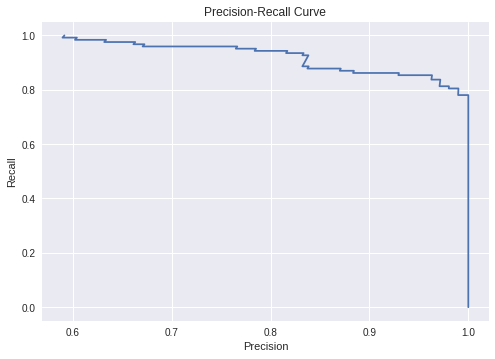

Recall: 0.8536585365853658
Precision: 0.9545454545454546
AUC for Precision-Recall curve: 0.9598849125180495


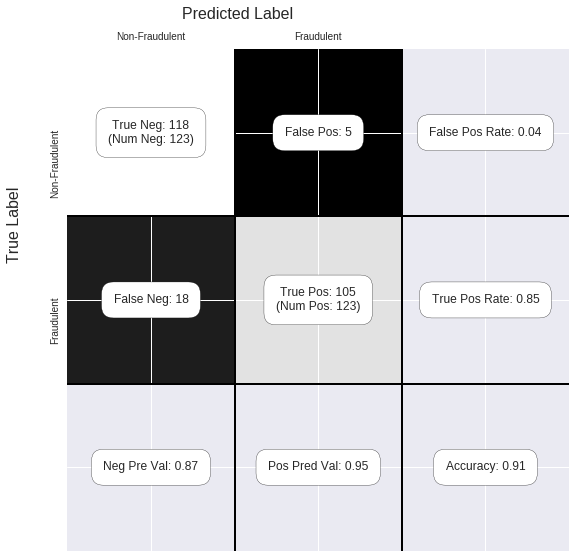

In [49]:
steps = [('scaler', StandardScaler()),
         ('GNB', GaussianNB())]

pipeline = Pipeline(steps)

pipeline.fit(X_train_subset,y_train_subset)

y_predic = pipeline.predict(X_test_subset)
y_pred = pipeline.predict_proba(X_test_subset)

prec, rec, thresholds = precision_recall_curve(y_test_subset, y_pred[:,1])
plt.plot(prec, rec)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

print("Recall: {}".format(recall_score(y_test_subset, y_predic)))
print("Precision: {}".format(precision_score(y_test_subset, y_predic)))
print("AUC for Precision-Recall curve: {}".format(metrics.auc(np.append(np.array([0.]),prec),np.append(np.array([1.]),rec),reorder=True)))

C=confusion_matrix(y_test_subset, y_predic)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### We notice a dramatic improvement in the precision-recall curve due to a great improvement in precision, but the improvement in recall is not that great. 

#### Let's look at the probability thresholds, and see what point on the curve gives the most satisfactory balance of recall and precision.

In [50]:
for i in thresholds:
    y_test_thresh = y_pred[:,1] > i
    re=recall_score(y_test_subset, y_test_thresh)
    pre=precision_score(y_test_subset, y_test_thresh)
    if re>0.94 and pre>0.8:
        print('------------------------------------------------------')
        print('Threshold set at '+str(i))
        print('Recall = {}'.format(re))
        print("Precision: {}".format(pre))
        print('------------------------------------------------------')

------------------------------------------------------
Threshold set at 6.49158300085e-13
Recall = 0.943089430894309
Precision: 0.8055555555555556
------------------------------------------------------
------------------------------------------------------
Threshold set at 8.51829758249e-13
Recall = 0.943089430894309
Precision: 0.8111888111888111
------------------------------------------------------
------------------------------------------------------
Threshold set at 1.03957160778e-12
Recall = 0.943089430894309
Precision: 0.8169014084507042
------------------------------------------------------


#### It looks like a value of $10^{-12}$ gives excellent values of recall and precision. Unfortunately, we are cherry-picking from the test set, which means this result may not generalize very well. However, it does inform us that we could gain additional performance by adding more 'weight' to the class of fraudulent transactions. We'll revisit this idea shortly.

#### It's time to try a new model. Next we look at Logistic Regression, a tried and true model that is very well understood in terms of its strengths and its weaknesses (model capacity being one potential weakness).

#### Unlike the Naive Bayes classifier, there are hyperparameters that can be tuned for logistic regression, and we will use k-folds cross-validation to help tune those hyperparameters. This means we need to pick the metric we seek to maximize in our model, and recall is the metric we will use, since we want to let as little fraud as possible go by undetected.

#### To deal with the class imbalance, rather than using the subsample we will first apply a class weight that penalizes incorrect classification of true fraudulent transactions. This feature is already built-in to scikit-learn's implementation of logistic regression, and can be selected by using the parameter 'class_weight'.

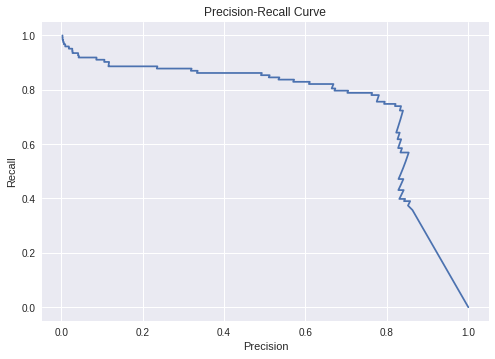

Tuned logreg Parameter: {'logreg__C': 0.1, 'logreg__penalty': 'l1'}
Tuned logreg Recall: 0.9078589136585403
Recall: 0.9186991869918699
Precision: 0.06288258208124652
AUC for Precision-Recall curve: 0.7453211979214943


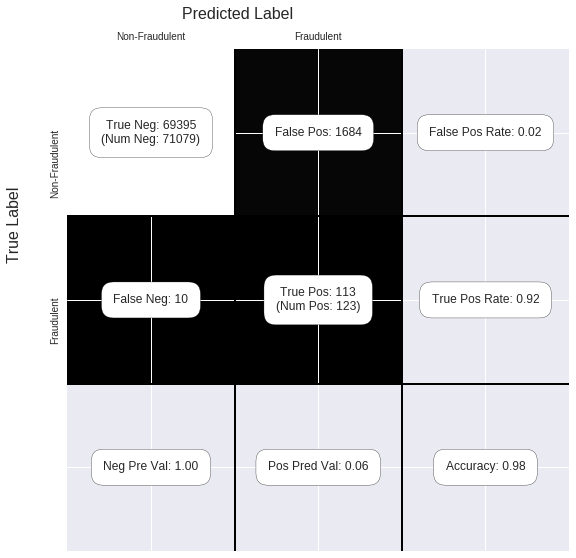

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


def scoring_model_Recall(estimator,X,y):
    z=estimator.predict(X)
    score=recall_score(y, z)
    return score

steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(class_weight='balanced'))]

pipeline = Pipeline(steps)


param_grid = { 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2']}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model_Recall)

logreg_cv.fit(X_train,y_train)

y_predic = logreg_cv.predict(X_test)
y_pred = logreg_cv.predict_proba(X_test)

prec, rec, thresholds = precision_recall_curve(y_test, y_pred[:,1])
plt.plot(prec, rec)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg Recall: {}".format(logreg_cv.best_score_))
print("Recall: {}".format(logreg_cv.score(X_test, y_test)))
print("Precision: {}".format(precision_score(y_test, y_predic)))
print("AUC for Precision-Recall curve: {}".format(metrics.auc(prec,rec,reorder=True)))

C=confusion_matrix(y_test, y_predic)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### Already this looks much better than Naive Bayes, since our recall has increased to almost 92%. Precision has dropped way down, but this is only a secondary concern, as the credit card company is most likely willing to over classify fraudulent transactions, if most of the fraudulent transactions are being correctly classified. Still the better model performance metric may be to use the area under the curve (AUC) with respect to the precision-recall curve. 

#### However, it should be noted that calculating the area under the precision-recall curve must be done with care. The paper http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf shows that using linear interpolation can lead to a dramatic overestimate of the area under the precision-recall curve. The 'auc' metric from sklearn.metric uses piecewise linear interpolation (i.e. the trapezoid quadrature rule), so this measure needs to be considered with skepticism.

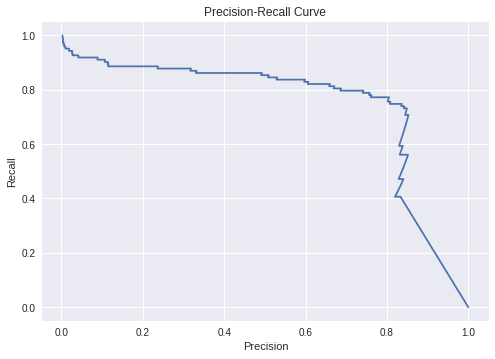

Tuned logreg Parameter: {'logreg__C': 100, 'logreg__penalty': 'l2'}
Tuned logreg AUC: 0.7809257260948329
Recall: 0.9186991869918699
Precision: 0.06305803571428571
AUC for Precision-Recall curve: 0.7693329414227847


IndexError: too many indices for array

In [52]:
from sklearn.metrics import average_precision_score

def scoring_model_AUC(estimator,X,y):
    z=estimator.predict_proba(X)
    prec, rec, thresholds = precision_recall_curve(y, z[:,1])
    score=metrics.auc(prec,rec,reorder=True)
    return score

steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(class_weight='balanced'))]

pipeline = Pipeline(steps)


param_grid = { 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2']}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model_AUC)

logreg_cv.fit(X_train,y_train)

y_predic = logreg_cv.predict(X_test)
y_pred = logreg_cv.predict_proba(X_test)

prec, rec, thresholds = precision_recall_curve(y_test, y_pred[:,1])
plt.plot(prec, rec)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg AUC: {}".format(logreg_cv.best_score_))
print("Recall: {}".format(recall_score(y_test, y_predic)))
print("Precision: {}".format(precision_score(y_test, y_predic)))
print("AUC for Precision-Recall curve: {}".format(metrics.auc(prec, rec,reorder=True)))
print("Average Precision Score: {}".format(average_precision_score(y_test, y_predic[:,1])))
C=confusion_matrix(y_test, y_predic)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### The class_weight defaults to penalizing based on the proportion of fraudulent transactions in the training set. We can customize the class weight and see if this gets us any increase in performance (i.e. recall). To do this we simply feed in weighting schemes as a hyperparameter into the cross validation process.

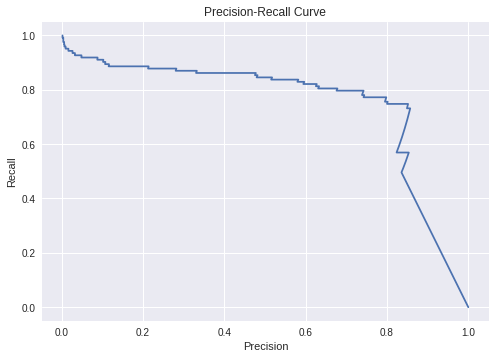

Tuned logreg Parameter: {'logreg__penalty': 'l2', 'logreg__C': 1000, 'logreg__class_weight': {0: 0.001, 1: 0.999}}
Tuned logreg AUC: 0.7838245175775296
Recall: 0.926829268292683
Precision: 0.03544776119402985
AUC for Precision-Recall curve: 0.7738176815245096


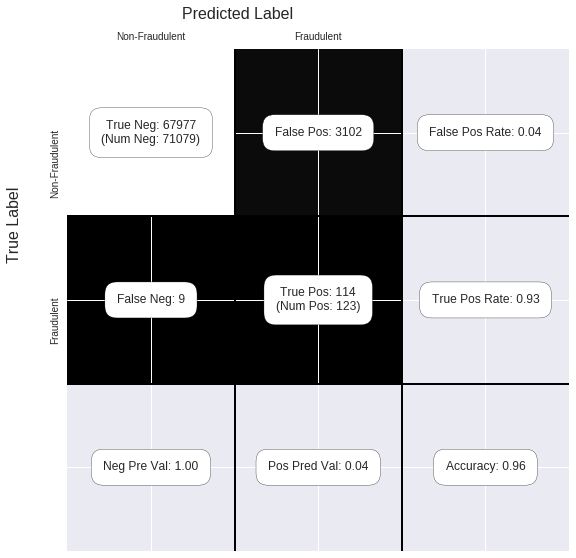

In [85]:
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)


param_grid = { 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2'],
              'logreg__class_weight':[{1:0.9995,0:0.0005},{1:0.999,0:0.001},{1:0.995,0:0.005},{1:0.99,0:0.01}]}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model_AvPrRe)

logreg_cv.fit(X_train,y_train)

y_predic = logreg_cv.predict(X_test)
y_pred = logreg_cv.predict_proba(X_test)

prec, rec, thresholds = precision_recall_curve(y_test, y_pred[:,1])
plt.plot(prec, rec)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg AUC: {}".format(logreg_cv.best_score_))
print("Recall: {}".format(recall_score(y_test, y_predic)))
print("Precision: {}".format(precision_score(y_test, y_predic)))
print("AUC for Precision-Recall curve: {}".format(metrics.auc(prec,rec,reorder=True)))

C=confusion_matrix(y_test, y_predic)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### It should be noted that the above logistic regressions took a long time to run on this moderately sized dataset. Even on a laptop with 16GB of RAM and an i7 Skylake Intel processor, dealing with the full datasetis a bit cumbersome. Let's see what we can do with the balanced subsample.

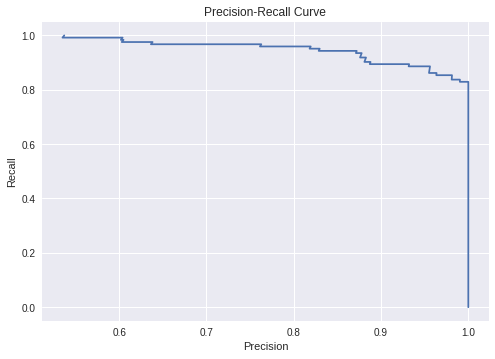

Tuned logreg Parameter: {'logreg__C': 0.01, 'logreg__penalty': 'l1'}
Tuned logreg AUC: 0.44551408896804773
Recall: 0.7804878048780488
Precision: 1.0
AUC for Precision-Recall curve: 0.4347818864408366
Average Precision Score: 0.9738370779863473


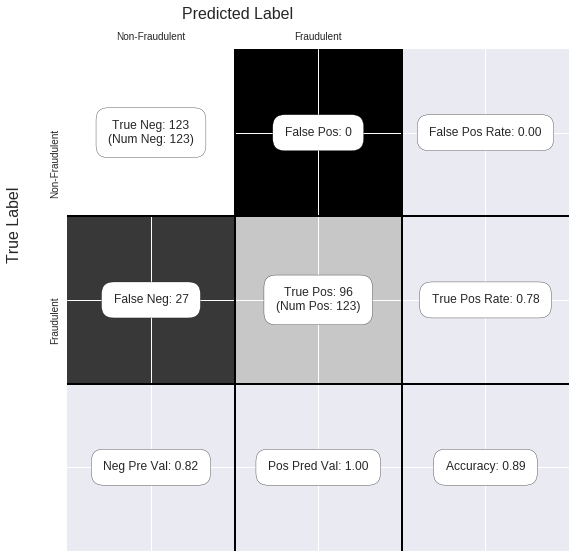

In [54]:
steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)


param_grid = { 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2']}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model_AUC)

logreg_cv.fit(X_train_subset,y_train_subset)

y_predic = logreg_cv.predict(X_test_subset)
y_pred = logreg_cv.predict_proba(X_test_subset)
y_score=logreg_cv.decision_function(X_test_subset)

prec, rec, thresholds = precision_recall_curve(y_test_subset, y_pred[:,1])
plt.plot(prec, rec)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg AUC: {}".format(logreg_cv.best_score_))
print("Recall: {}".format(recall_score(y_test_subset, y_predic)))
print("Precision: {}".format(precision_score(y_test_subset, y_predic)))
print("AUC for Precision-Recall curve: {}".format(metrics.auc(prec,rec,reorder=True)))
print("Average Precision Score: {}".format(average_precision_score(y_test_subset, y_score)))


C=confusion_matrix(y_test_subset, y_predic)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### Since we are interested primarily in recall, but also in precision a weighted average of these scores may be a suitable metric for cross-validation. Note that the F1-score is the geometric mean of these two scores, so it penalizes either score being low. F1-score may have a role to play here, but for now we will try a weighted average of precision and recall.

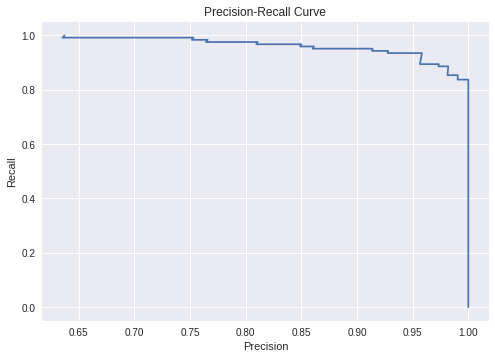

Tuned logreg Parameter: {'logreg__C': 10, 'logreg__penalty': 'l1'}
Tuned logreg Average PR: 0.9381954685825928
Recall: 0.9349593495934959
Precision: 0.9504132231404959
AUC for Precision-Recall curve: 0.3458997645266447
Average Precision Score: 0.9852333600042431


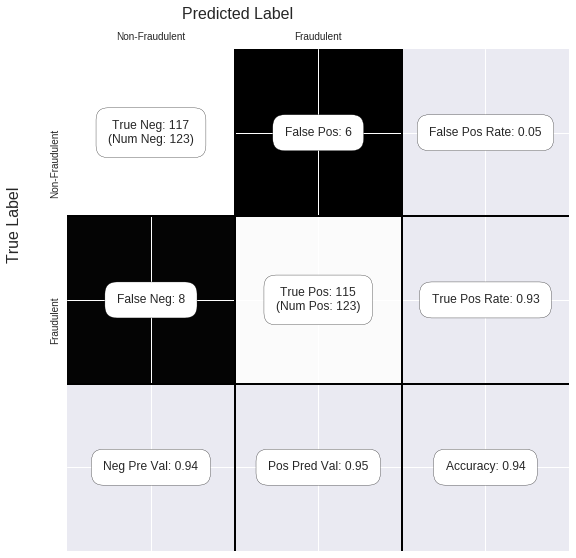

In [158]:
def scoring_model_AvPrRe(estimator,X,y):
    z=estimator.predict(X)
    precision=precision_score(y, z)
    recall=recall_score(y, z)
    score=0.9*recall+0.1*precision
    return score

steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(class_weight={0:1,1:3}))]

pipeline = Pipeline(steps)


param_grid = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2']}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model_AvPrRe)

logreg_cv.fit(X_train_subset,y_train_subset)

y_predic = logreg_cv.predict(X_test_subset)
y_pred = logreg_cv.predict_proba(X_test_subset)
y_score=logreg_cv.decision_function(X_test_subset)

prec, rec, thresholds = precision_recall_curve(y_test_subset, y_pred[:,1])
plt.plot(prec, rec)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg Average PR: {}".format(logreg_cv.best_score_))
print("Recall: {}".format(recall_score(y_test_subset, y_predic)))
print("Precision: {}".format(precision_score(y_test_subset, y_predic)))
print("AUC for Precision-Recall curve: {}".format(metrics.auc(prec,rec,reorder=True)))
print("Average Precision Score: {}".format(average_precision_score(y_test_subset, y_score)))


C=confusion_matrix(y_test_subset, y_predic)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### Let's see how this fitted model performs on the remaining portion of the dataset. This will give us a better feel for how the model will generalize. Note that recall will be the same, since all of the fraud observations were included in the subsampled train and test set.

Recall: 0.9349593495934959
Precision: 0.0058316430020283975


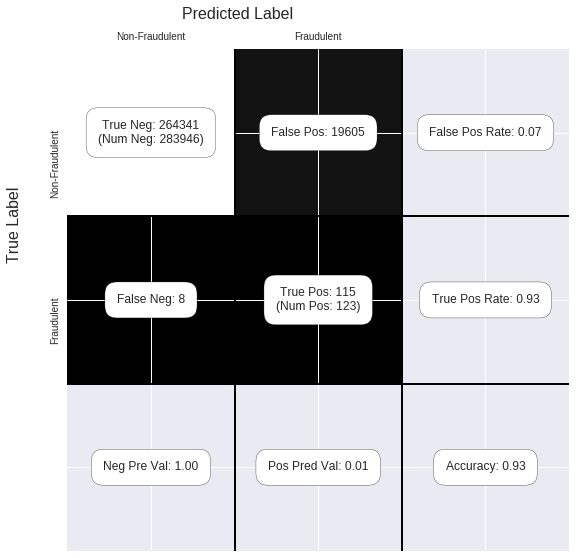

In [155]:
X_combined_test=np.concatenate((X_remaining,X_test_subset),axis=0)
y_combined_test=np.concatenate((y_remaining,y_test_subset),axis=0)
z=logreg_cv.predict(X_combined_test)
print("Recall: {}".format(recall_score(y_combined_test, z)))
print("Precision: {}".format(precision_score(y_combined_test, z)))
C=confusion_matrix(y_combined_test, z)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### Our model does not seem to be doing well when we test it on a larger set with a realistic ratio  of non-fraudulent transactions to fraudulent transactions, and our precision score has dropped below 1%! The class weight scheme applied to logistic regression on the full dataset is giving the more reliable generalization. Subsampling based on a random sample will only get us so far.

#### We will look at ensemble methods based on multiple subsamples, but there is also a smarter way to subsample particularly with respect to logistic regression. This way is outlined here: https://arxiv.org/pdf/1306.3706.pdf

#### Additionally, there is a correction that can be made to the intercept value given by fitting logistic regression from undersampling (see https://en.wikipedia.org/wiki/Logistic_regression#Case-control_sampling ). We will see if this helps our model.

In [130]:
alpha=logreg_cv.best_estimator_.named_steps['logreg'].intercept_
beta=logreg_cv.best_estimator_.named_steps['logreg'].coef_
alpha_update=alpha+np.log(0.001727/(1-0.001727))+np.log(0.5/(1-0.5)) 

In [2]:
scaler=StandardScaler()
scaler.fit(X_train_subset)
X=scaler.transform(X_combined_test)

NameError: name 'StandardScaler' is not defined

In [147]:
y_score=1/(1+np.exp(-(np.dot(X,beta.T)+alpha)))
y_predict=y_score>=0.5
y_predict

array([[False],
       [False],
       [False],
       ..., 
       [ True],
       [ True],
       [False]], dtype=bool)

Recall: 0.8861788617886179
Precision: 0.017709179528838343


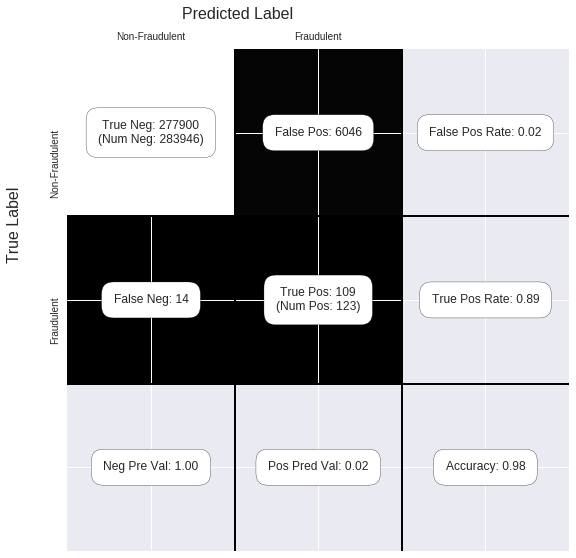

In [148]:
print("Recall: {}".format(recall_score(y_combined_test, y_predict)))
print("Precision: {}".format(precision_score(y_combined_test, y_predict)))
C=confusion_matrix(y_combined_test, y_predict)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

Recall: 0.8617886178861789
Precision: 0.038170687792581925


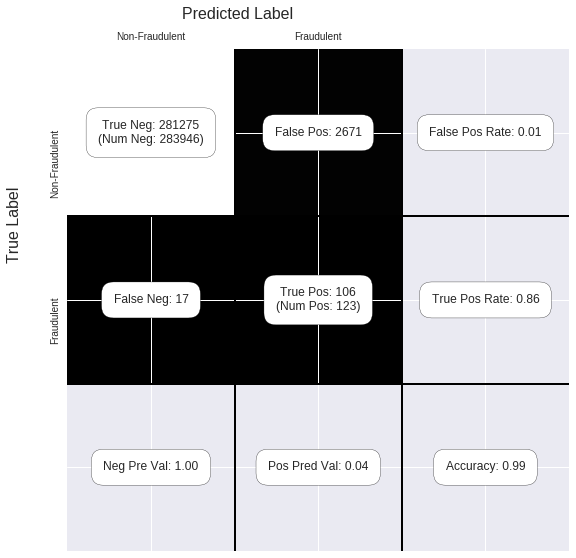

In [144]:
y_score=1/(1+np.exp(-(np.dot(X,beta.T)+alpha_update)))
y_predict=y_score>0.005
print("Recall: {}".format(recall_score(y_combined_test, y_predict)))
print("Precision: {}".format(precision_score(y_combined_test, y_predict)))
C=confusion_matrix(y_combined_test, y_predict)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### I recently read the tutorial on Gradient Boosting by Kaggle Master Ben Gorman (http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/), and it sounds like it can do quite well on imbalanced datasets. A sequence of learners are trained, each successive learner trys to learn from the mistakes of the previous learner (i.e. boosting). I've implemented a basic gradient boosting classifier below, and not only did it take a very long time to run, bu the results were disappointing. The lesson is that I need to get better at tuning boosting models.

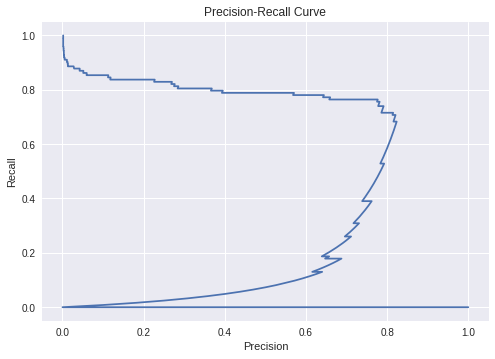

Tuned logreg Parameter: {'gboost__max_depth': 5, 'gboost__n_estimators': 50, 'gboost__learning_rate': 0.05}
Tuned logreg Average PR: 0.7506773291557265
Recall: 0.7642276422764228
Precision: 0.7704918032786885
AUC for Precision-Recall curve: 0.6599404999373565
Average Precision Score: 0.566133116367646


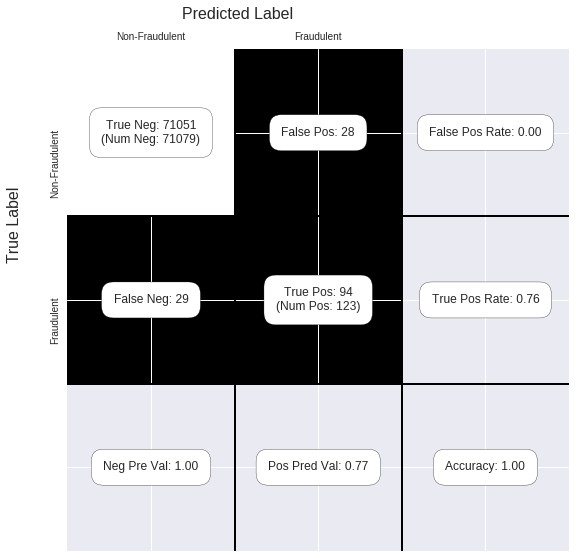

In [157]:
from sklearn.ensemble import GradientBoostingClassifier

steps = [('scaler', StandardScaler()),
         ('gboost', GradientBoostingClassifier())]

pipeline = Pipeline(steps)


param_grid = { 'gboost__learning_rate': [0.01,0.05,0.1,0.25,0.5],
              "gboost__n_estimators": [50,100,200],
              "gboost__max_depth": [2,3,4,5]}

gboost_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model_AvPrRe)

gboost_cv.fit(X_train,y_train)

y_predic = gboost_cv.predict(X_test)
y_pred = gboost_cv.predict_proba(X_test)
y_score=gboost_cv.decision_function(X_test)

prec, rec, thresholds = precision_recall_curve(y_test, y_pred[:,1])
plt.plot(prec, rec)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(gboost_cv.best_params_))
print("Tuned logreg Average PR: {}".format(gboost_cv.best_score_))
print("Recall: {}".format(recall_score(y_test, y_predic)))
print("Precision: {}".format(precision_score(y_test, y_predic)))
print("AUC for Precision-Recall curve: {}".format(metrics.auc(prec,rec,reorder=True)))
print("Average Precision Score: {}".format(average_precision_score(y_test, y_score)))


C=confusion_matrix(y_test, y_predic)
show_confusion_matrix(C,class_labels=['Non-Fraudulent','Fraudulent'])

#### Gradient boosting does have the nice result of showing which features were the most important in the classification process.

#### I've printed out the ranking of features below, and there does appear to a truely dominate feature(s).

In [163]:
gboost_cv.best_estimator_.named_steps['gboost'].feature_importances_

array([ 0.02805649,  0.0060309 ,  0.00731619,  0.01902645,  0.14070221,
        0.00072622,  0.00626276,  0.00956786,  0.00061872,  0.00079053,
        0.01715571,  0.05000937,  0.01945519,  0.13593452,  0.13156896,
        0.01509513,  0.04561257,  0.03072293,  0.0007683 ,  0.07807177,
        0.01693637,  0.01996412,  0.01785607,  0.01775221,  0.03408835,
        0.06973083,  0.00359489,  0.01612654,  0.01171593,  0.0487419 ])